## Quiz #0503

### "Data Augmentation"

#### Answer the following questions by providing Python code:
#### Objectives:
- Code the helper functions.
- Optimize and test a predictive model of your choice.
- Carry out data aumentation in order to improve the predictive accuracy when the given training data is small.

In [23]:
import numpy as np
import pandas as pd
import os
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn import metrics, preprocessing
from scipy.ndimage.interpolation import rotate
warnings.filterwarnings(action='ignore')                  # Turn off the warnings.
%matplotlib inline

#### Read in data:
The explanation on the original data can be found [here](http://yann.lecun.com/exdb/mnist/).

- The data we will be using is a small subset of the original data with only 100 observations.
- Each observation is the "flattened" version of a image.
- The first column corresponds to the label (Y).
- The image size is 28x28.

In [24]:
# Read the training and testing data separately.
data_train = pd.read_csv('data_mnist_train_100.csv', header=None,encoding='latin1')
data_test = pd.read_csv('data_mnist_test_100.csv', header=None,encoding='latin1')

# Scale and split the data set into X and Y.
X_train = np.array((data_train.iloc[:,1:]/255.0)*0.99+0.01)
X_test = np.array((data_test.iloc[:,1:]/255.0)*0.99+0.01)
Y_train = np.array(data_train.iloc[:,0])
Y_test = np.array(data_test.iloc[:,0])

1). The helper function 'show_data()' visualizes each given observation.

In [25]:
def show_data(X, Y, n, angle=0):
    image_matrix = X[n,:].reshape((28,28))
    image_matrix = rotate(image_matrix, angle, cval=0.01, reshape=False)
    imax = image_matrix.max()
    imin = image_matrix.min()
    image_matrix = ((image_matrix-imin)/(imax-imin))*0.99+0.01
    plt.imshow(image_matrix, cmap='Greys',interpolation='None')
    print(Y[n])

6


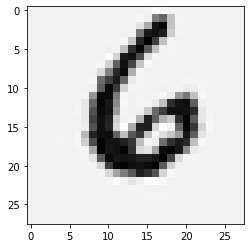

In [26]:
# Example 1.
show_data(X_train, Y_train,10,10)

6


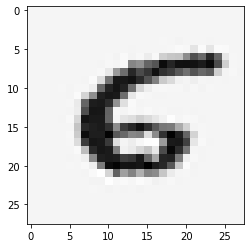

In [27]:
# Example 2.
show_data(X_train, Y_train,10,-30)

0


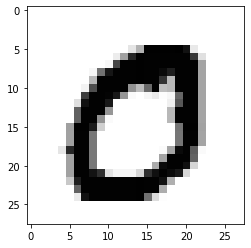

In [28]:
# Example 3.
show_data(X_train, Y_train,77,0)

2). Choose an algorithm and carry out the predictive analysis.

- Optimize the hyperparameter(s).
- Calculate the accuracy.
- Is the accuracy high enough?

In [29]:
print(X_train.shape)
print(Y_train.shape)

(100, 784)
(100,)


In [30]:
from sklearn import model_selection
#lets choos an algorithm using cross validation
models = {
	'KNN': KNeighborsClassifier(2),
	'Decision Tree': DecisionTreeClassifier(),
	'Random Forest': RandomForestClassifier(),
	'AdaBoost': AdaBoostClassifier(),
	'XGBoost': XGBClassifier(eval_metric="mlogloss")
}

results = []
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test,axis=0)

for name in models:
	print("%s Running..." % name)
	kfold = model_selection.KFold(n_splits=10, random_state=0, shuffle=True)
	cv_results = model_selection.cross_val_score(models[name], X_train, Y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	print("\t mean_accuracy = %f" % cv_results.mean())
	print("\t std = %f" % cv_results.std())


KNN Running...
	 mean_accuracy = 0.790000
	 std = 0.130000
Decision Tree Running...
	 mean_accuracy = 0.450000
	 std = 0.143178
Random Forest Running...
	 mean_accuracy = 0.740000
	 std = 0.101980
AdaBoost Running...
	 mean_accuracy = 0.160000
	 std = 0.080000
XGBoost Running...
	 mean_accuracy = 0.680000
	 std = 0.124900


The best accuracy was obtained with KNN. with 77%
let's tune its parameters

In [31]:
knn = KNeighborsClassifier()

for k in range(1,20,2):
    knn.n_neighbors = k
    knn.fit(X_train, Y_train)
    print("k =", k)
    print("\tAccuracy: %f" % knn.score(X_test, Y_test))

k = 1
	Accuracy: 0.670000
k = 3
	Accuracy: 0.660000
k = 5
	Accuracy: 0.650000
k = 7
	Accuracy: 0.680000
k = 9
	Accuracy: 0.670000
k = 11
	Accuracy: 0.640000
k = 13
	Accuracy: 0.570000
k = 15
	Accuracy: 0.580000
k = 17
	Accuracy: 0.560000
k = 19
	Accuracy: 0.590000


the accuracy is a bit low and it can be improved

3). Code the helper function 'rotate_data()' that rotates each given observation by an angle. HINT: use scipy.ndimage.interpolation().

In [32]:
def rotate_data(X ,angle):
    X_rotated = np.zeros((X.shape[0],X.shape[1]))
    for i in range(X.shape[0]):
        image_matrix = X[i,:].reshape((28,28))
        X_rotated[i] = rotate(image_matrix, angle, cval=0.01, reshape=False).reshape(784)
    return X_rotated

(100, 784)
6


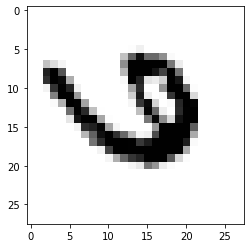

In [33]:
t = rotate_data(X_train, 90)
print(X_train.shape)

show_data(t, Y_train,10,0)


4). Augment the training dataset.
- Increase the size of the training dataset by introducing slight rotations (clockwise and counterclockwise).
- Use the 'rotate_data()' function defined in the previous step.
- No need to augment the testing dataset.
- Target approximately five fold aumentation.

In [34]:
# we will augment data by rotating it by +-45 degrees (maximum angle)
# because these are number and they cannot be completely flipped

# five fold data augementation
augmented_X_trains = []
for angle in range(20, 45, 10):
       print(angle)
       # clockwise rotation
       augmented_X_trains.append(rotate_data(X_train, angle))
       # counterclockwise rotation
       augmented_X_trains.append(rotate_data(X_train, -angle))

augmented_X_train = X_train
augmented_Y_train = Y_train

for aug in augmented_X_trains:
    augmented_X_train = np.append(X_train,aug,axis=0)
    augmented_Y_train = np.append(Y_train,Y_train,axis=0)

20
30
40


In [35]:
print(augmented_X_train.shape)
print(augmented_Y_train.shape)


(200, 784)
(200,)


5). Redo the predictive analysis with the augmented training dataset.

- Use the same algorithm as in the step 2).
- Calculate the accuracy.
- Has the accuracy gone up?

In [36]:
from sklearn import model_selection
#lets choos an algorithm using cross validation
models = {
	'KNN': KNeighborsClassifier(2),
	'Decision Tree': DecisionTreeClassifier(),
	'Random Forest': RandomForestClassifier(),
	'AdaBoost': AdaBoostClassifier(),
	'XGBoost': XGBClassifier(eval_metric="mlogloss")
}

results = []
X = np.append(augmented_X_train, X_test,axis=0)
Y = np.append(augmented_Y_train, Y_test,axis=0)

for name in models:
	print("%s Running..." % name)
	kfold = model_selection.KFold(n_splits=10, random_state=0, shuffle=True)
	cv_results = model_selection.cross_val_score(models[name], X_train, Y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	print("\t mean_accuracy = %f" % cv_results.mean())
	print("\t std = %f" % cv_results.std())


KNN Running...
	 mean_accuracy = 0.790000
	 std = 0.130000
Decision Tree Running...
	 mean_accuracy = 0.440000
	 std = 0.120000
Random Forest Running...
	 mean_accuracy = 0.730000
	 std = 0.110000
AdaBoost Running...
	 mean_accuracy = 0.160000
	 std = 0.080000
XGBoost Running...
	 mean_accuracy = 0.680000
	 std = 0.124900


# we can see that the overall accuracy augmented for the algorithms